In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Functions

In [12]:
import seaborn as sns
import umap
from sklearn.decomposition import PCA

def generate_pca_embedding(matrix, n_components=2):
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(matrix.T)
    if isinstance(matrix, pd.DataFrame):
        embedding = pd.DataFrame(embedding, index=matrix.columns, columns=[f'PCA{i+1}' for i in range(n_components)])
    return embedding

def generate_umap_embedding(matrix, n_components=2):

    reducer = umap.UMAP(n_components=n_components)
    embedding = reducer.fit_transform(matrix.T)
    if isinstance(matrix, pd.DataFrame):
        embedding = pd.DataFrame(embedding, index=matrix.columns, columns=[f'UMAP{i+1}' for i in range(n_components)])
    return embedding

def plot_pca(embedding,metadata,col_name,yes_umap=False):

    if yes_umap:
        xvar = 'UMAP1'
        yvar = 'UMAP2'
    else:
        xvar = 'PCA1'
        yvar = 'PCA2'
    if metadata[col_name].nunique() < 10:
        palette = sns.color_palette("tab10", metadata[col_name].nunique())
        sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=metadata[col_name], palette=palette)
    else:
        sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=metadata[col_name])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=col_name)
    plt.xlabel(xvar)
    plt.ylabel(yvar)

    # add counts to the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if metadata[col_name].nunique() < 15:
        labels = [f'{x} ({metadata[metadata[col_name]==x].shape[0]})' for x in labels]
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=col_name,
            ncol=2)  # ncol=2 makes the legend have 2 columns

    # add the number of samples to the title
    plt.title(f'N samples = {metadata[~metadata[col_name].isna()].shape[0]}')
    
def align_to_existing(input_intensity_matrix, pretrain_features, align_input, 
                      fill_na=False, std_scale=False, log2_scale=False,verbose=1):
    """
    Aligns input intensity matrix with pretrain features based on align input.

    Parameters:
    - input_intensity_matrix (pd.DataFrame): The input intensity matrix to align. Columns are features and rows are samples.
    - pretrain_features (list or pd.Index): The list or pd.Index of features used for pretraining (correspond to reference study features)
    - align_input (pd.DataFrame or pd.Series): The align input to use for alignment. has index of features from the reference study, 
    and values of the features from the input_intensity_matrix to align.
    - fill_na (bool, optional): Whether to fill missing values. Defaults to False. Missing values within the input study, 
        are filled by taking the average feature value, while features not present in the input study are filled by taking the average sample value.
    - std_scale (bool, optional): Whether to standardize the intensity matrix. Defaults to False.
    - log2_scale (bool, optional): Whether to log2 transform the intensity matrix. Defaults to False.

    Returns:
    - intensity_df (pd.DataFrame): The aligned intensity matrix.
    - nan_df (pd.DataFrame): A boolean DataFrame indicating missing values in the aligned intensity matrix.
    """
    if not isinstance(input_intensity_matrix, pd.DataFrame):
        raise ValueError('input_intensity_matrix should be a pandas DataFrame')

    if 'FT' not in input_intensity_matrix.columns[0][:2]:
        input_intensity_matrix = input_intensity_matrix.T

    if isinstance(align_input,pd.DataFrame):
        align_input = align_input.iloc[:,0].copy()

    common_pretrained_features = list(set(pretrain_features).intersection(align_input.index))
    if verbose > 1: print('Common pretrained features:', common_pretrained_features)
    if verbose > 0: print('number of common pretrained features:', len(common_pretrained_features))
    missing_pretrained_features = list(set(pretrain_features).difference(align_input.index))
    if verbose > 1: print('Missing pretrained features:', missing_pretrained_features)
    if verbose > 0: print('number of missing pretrained features:', len(missing_pretrained_features))
    align_input = align_input[common_pretrained_features].copy()
    
    input_features_aligned = align_input.values.tolist()
    pretrain_features_aligned = align_input.index.tolist()
    if isinstance(pretrain_features, pd.Index):
        pretrain_features = pretrain_features.tolist()
    

    output_matrix = np.empty((input_intensity_matrix.shape[0], len(pretrain_features)), dtype=float)
    output_matrix = output_matrix * np.nan
    output_matrix[:, [pretrain_features.index(f) for f in pretrain_features_aligned]] = input_intensity_matrix[input_features_aligned].values

    intensity_df = pd.DataFrame(output_matrix, index=input_intensity_matrix.index, columns=pretrain_features)
    nan_df = intensity_df.isnull()

    if log2_scale:
        intensity_df = np.log2(intensity_df + 1)

    if std_scale:
        scaler = StandardScaler()
        intensity_df = pd.DataFrame(scaler.fit_transform(intensity_df), index=intensity_df.index, columns=intensity_df.columns)
        
    if fill_na:
        # Fill partial missing values with the mean of the feature
        partial_missing = intensity_df.loc[:,pretrain_features_aligned].copy()
        full_missing = intensity_df.loc[:, [f for f in pretrain_features if f not in pretrain_features_aligned]].copy()
        partial_missing.fillna(partial_missing.mean(), inplace=True)

        # fill complete missing values rest with the mean of row
        full_missing = full_missing.T
        full_missing.fillna(intensity_df.mean(axis=1), inplace=True)
        full_missing = full_missing.T

        intensity_df = pd.concat([partial_missing, full_missing], axis=1)
        intensity_df = intensity_df[pretrain_features]


    return intensity_df, nan_df

## Example #1

### Get the list of features used for pretraining

In [6]:
#Load the pretrained features corresponding to the Ref Study (ST001237)
pretrain_feats_file = 'pretrain_feats.txt'
pretrain_feats = pd.read_csv(pretrain_feats_file, header=None)[0].tolist()

In [3]:
# x_rcc_test_file = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/April_30_Finetune_Data/X_finetune_test.csv'
# x_rcc_test = pd.read_csv(x_rcc_test_file, index_col=0)
# pretrain_feats = x_rcc_test.columns

# # save the pretrain features to a list
# pretrain_feats_file = 'pretrain_feats.txt'
# with open(pretrain_feats_file, 'w') as f:
#     for item in pretrain_feats:
#         f.write("%s\n" % item)

In [8]:
# The base directory for saving stuff
SAVE_BASE_DIR = ''

### Load the new study to be added to the pretraining with the metadata

In [9]:
standford_data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/stanford-hmp2'
metab_study_name = 'stanford_hmp2'
new_alignment_df = pd.read_csv(f'{standford_data_dir}/alignment_df.csv', index_col=0)
new_alignment_df.dropna(axis=0, how='all', inplace=True)

In [10]:
new_metadata = pd.read_csv(f'{standford_data_dir}/stanford-hmp2_metadata.tsv', index_col=0, sep='\t')

new_metadata['file name'] = new_metadata.index
new_metadata['mzml_file'] = new_metadata['file name'].apply(lambda x: x+'.mzML')
new_metadata.index = new_metadata['mzml_file']

sample_info = pd.read_csv(f'{standford_data_dir}/sample_info.csv', index_col=0)
new_metadata =new_metadata.join(sample_info,how='outer')

#### Align the input study to the pretraining features

In [13]:

poolmap_intensity = pd.read_csv(f'{standford_data_dir}/final_peaks_intensity_max_pool_map_norm.csv', index_col=0)
intensity_df, nan_df = align_to_existing(poolmap_intensity.T, pretrain_feats, new_alignment_df['627'], fill_na=True, std_scale=True, log2_scale=True)

number of common pretrained features: 1767
number of missing pretrained features: 969


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### Visualize results to confirm that the new study is properly normalized

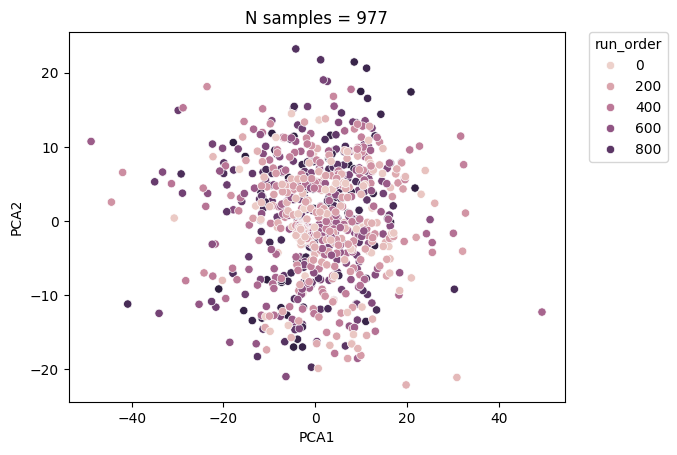

In [14]:
embedding0 = generate_pca_embedding(intensity_df.T).values

plot_pca(embedding0,new_metadata,col_name='run_order',yes_umap=False)

### Save the prepared study to be used for pretraining

In [ ]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
new_metadata.to_csv(f'{save_dir}/metadata.csv')